In [29]:
import numpy as np
import matplotlib.pyplot as plt

from braitenberg_environment import BraitenbergEnvironment

from learning_rules import Neuron, Synapse, double_exponential

In [30]:

b = BraitenbergEnvironment(filename="parcour_2.png",
                           vehicle_diameter=15., 
                           antenna_angle=30./180.*np.pi, 
                           initial_orientation=25./180*np.pi, 
                           short_antenna_length = 5.,
                           long_antenna_length  = 30.)
T_final = 20000
times, xdata, ydata = [], [], []
motor_command = 0 
threshold = 0.01

for t in range(T_final):
    x, y, _, sensors = b.world_update(motor_command)
    times.append(t)
    xdata.append(x)
    ydata.append(y)
    
    left_contact    = sensors[0]
    right_contact   = sensors[1]
    left_predictor  = sensors[2]
    right_predictor = sensors[3]

    # If the object is closer than a threshold value from obstacles, adjust movement
    if left_contact > threshold or left_predictor > threshold:
        motor_command = -np.pi / 8 
    elif right_contact > threshold or right_predictor > threshold:
        motor_command = np.pi / 8
    else:
        motor_command = 0

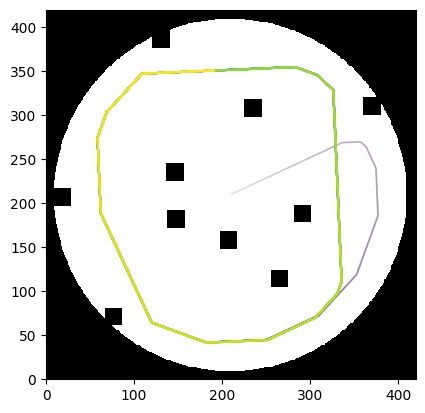

In [31]:
fig = plt.figure()
ax  = plt.subplot(111, aspect=1)
p0  = plt.pcolor(b.worldmap.T, cmap='Greys')

plt.scatter(xdata, ydata, lw=0.5, s=1, 
          c=np.array(times)*1./T_final, # later times, brighter color
          alpha=(0.01 + 0.99*np.array(times)/T_final) , # later times, lower transparency
          )
plt.show()

In [32]:
l_0 = 5
l_1 = 30
angle = np.pi/6
d = 15
g_alpha = 50
orientation_init = 25/180 * np.pi
T_tot = 20000
learning_rate = 0.6
dt = 1

X_L_0 = Neuron(0)
X_R_0 = Neuron(0)
X_L_1 = Neuron(0)
X_R_1 = Neuron(0)
X_L = Neuron(0)
X_R = Neuron(0)

s_L_0 = Synapse(X_L_0, X_L, learning_rate, weight=1)
s_R_0 = Synapse(X_R_0, X_R, learning_rate, weight=1)
s_R_1 = Synapse(X_R_1, X_R, learning_rate)
s_L_1 = Synapse(X_L_1, X_L, learning_rate)

motor_out = Neuron(0)
s_L_out = Synapse(X_L, motor_out, learning_rate, weight=-g_alpha)
s_R_out = Synapse(X_R, motor_out, learning_rate, weight=g_alpha)

b_2 = BraitenbergEnvironment(filename="parcour_2.png",
                           vehicle_diameter=d, 
                           antenna_angle=angle, 
                           initial_orientation=orientation_init, 
                           short_antenna_length = l_0,
                           long_antenna_length  = l_1)

In [33]:
motor_command = 0

X= []
Y = []
list_t = np.arange(T_tot)
reflex_signals = []

for t in list_t:
    x_t, y_t, orientation_t, sensors_t = b.world_update(motor_command)
    X.append(x_t)
    Y.append(y_t)

    X_L_0.rate = sensors_t[0]
    X_R_0.rate = sensors_t[1]
    X_L_1.rate = sensors_t[2]
    X_R_1.rate = sensors_t[3]

    r = np.max([X_L_0.rate, X_R_0.rate])
    reflex_signals.append(r)
    
    X_L.update_rate([s_L_0.weight, s_L_1.weight], [X_L_0.rate, X_L_1.rate])
    X_R.update_rate([s_R_0.weight, s_R_1.weight], [X_R_0.rate, X_R_1.rate])
    motor_out.update_rate([s_L_out.weight, s_R_out.weight], [X_L.rate, X_R.rate])

    motor_command = motor_out.rate

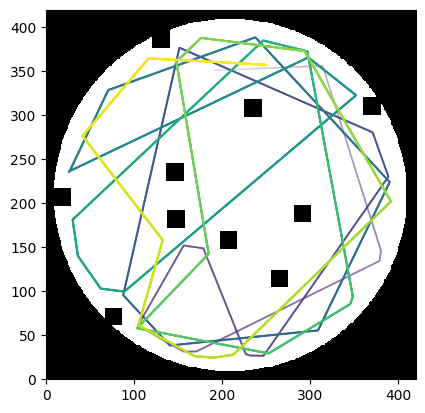

In [34]:
fig = plt.figure()
ax  = plt.subplot(111, aspect=1)
p0  = plt.pcolor(b_2.worldmap.T, cmap='Greys')

plt.scatter(X, Y, lw=0.5, s=1, 
          c=np.array(list_t)*1./T_tot, # later times, brighter color
          alpha=(0.01 + 0.99*np.array(list_t)/T_tot) , # later times, lower transparency
          )
plt.show()

Text(0, 0.5, 'reflex signal')

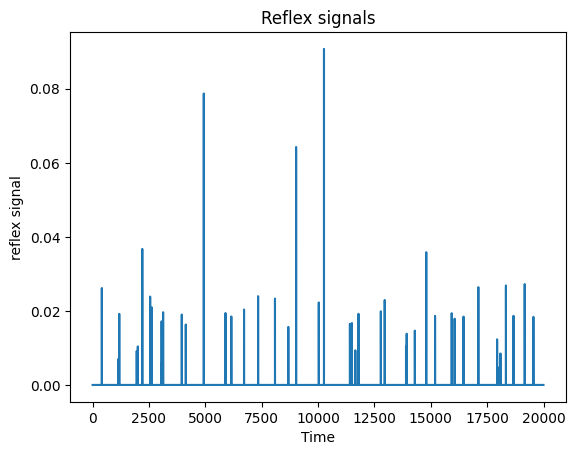

In [35]:
plt.plot(list_t, reflex_signals)
plt.title('Reflex signals')
plt.xlabel('Time')
plt.ylabel('reflex signal')

 Use your ICO synapses to extend the controller with reflex-avoidance-learning using the XL/R Antennas as predictors of length l1 = 30. To your protocol, add plots for the trajectory, and weight development together with the reflex signal. Do the weights converge? Compare plots of reflex arousal at the beginning and end of your simulation. What determines the rotation angle?  

In [36]:

X_L_0 = Neuron(0)
X_R_0 = Neuron(0)
X_L_1 = Neuron(0)
X_R_1 = Neuron(0)
X_L = Neuron(0)
X_R = Neuron(0)

s_L_0 = Synapse(X_L_0, X_L, learning_rate, weight=1)
s_R_0 = Synapse(X_R_0, X_R, learning_rate, weight=1)
s_R_1 = Synapse(X_R_1, X_R, learning_rate)
s_L_1 = Synapse(X_L_1, X_L, learning_rate)

motor_out = Neuron(0)
s_L_out = Synapse(X_L, motor_out, learning_rate, weight=-g_alpha)
s_R_out = Synapse(X_R, motor_out, learning_rate, weight=g_alpha)

motor_command = 0

X= []
Y = []
list_t = np.arange(T_tot)
reflex_signals = []

list_weight_L = []
list_weight_R = []

for t in list_t:
    x_t, y_t, orientation_t, sensors_t = b_2.world_update(motor_command)
    X.append(x_t)
    Y.append(y_t)

    X_L_0.rate = sensors_t[0]
    X_R_0.rate = sensors_t[1]
    X_L_1.rate = sensors_t[2]
    X_R_1.rate = sensors_t[3]
    X_L_1.rates.append(X_L_1.rate)
    X_R_1.rates.append(X_R_1.rate)
    X_L_0.rates.append(X_L_0.rate)
    X_R_0.rates.append(X_R_0.rate)

    r = np.max([X_L_0.rate, X_R_0.rate])
    reflex_signals.append(r)
    
    X_L.update_rate([s_L_0.weight, s_L_1.weight], [X_L_0.rate, X_L_1.rate])
    X_R.update_rate([s_R_0.weight, s_R_1.weight], [X_R_0.rate, X_R_1.rate])
    
    motor_out.update_rate([s_L_out.weight, s_R_out.weight], [X_L.rate, X_R.rate])

    motor_command = motor_out.rate
    
    s_L_1.update_weight('ico2')
    s_R_1.update_weight('ico2')
    list_weight_R.append(s_R_1.weight)
    list_weight_L.append(s_L_1.weight)
    
list_rates_L = X_L.rates
list_rates_R = X_R.rates

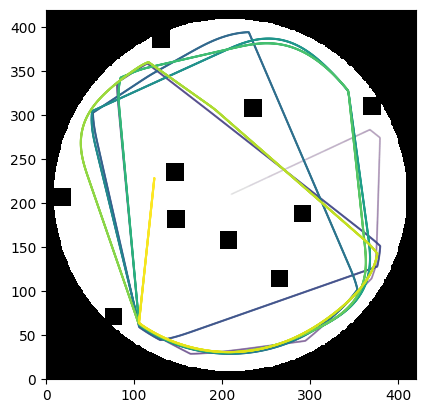

In [37]:
fig = plt.figure()
ax  = plt.subplot(111, aspect=1)
p0  = plt.pcolor(b_2.worldmap.T, cmap='Greys')

plt.scatter(X, Y, lw=0.5, s=1, 
          c=np.array(list_t)*1./T_tot, # later times, brighter color
          alpha=(0.01 + 0.99*np.array(list_t)/T_tot) , # later times, lower transparency
          )
plt.show()

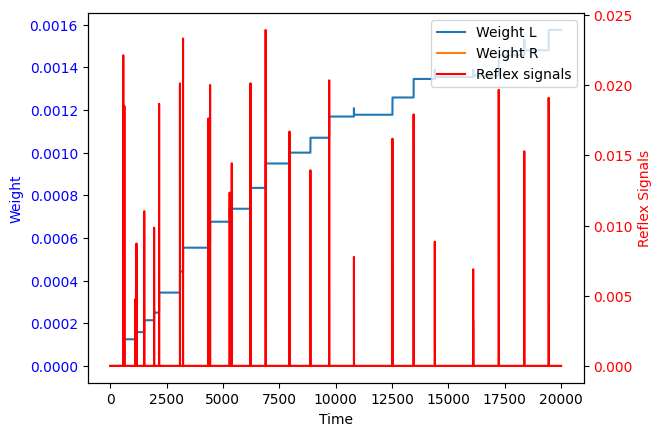

In [38]:
# Plot the primary y-axis data
fig, ax1 = plt.subplots()

# Plot Weight L and Weight R on the primary y-axis
ax1.plot(list_t, list_weight_L, label="Weight L")
ax1.plot(list_t, list_weight_R, label="Weight R")
ax1.set_xlabel("Time")
ax1.set_ylabel("Weight", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a twin y-axis to rescale reflex signals
ax2 = ax1.twinx()
ax2.plot(list_t, reflex_signals, label="Reflex signals", color='red')
ax2.set_ylabel("Reflex Signals", color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add legends
fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)

# Show the plot
plt.show()

In [39]:
b_3 = BraitenbergEnvironment(filename="parcour_2.png",
                           vehicle_diameter=d, 
                           antenna_angle=angle, 
                           initial_orientation=orientation_init, 
                           short_antenna_length = l_0,
                           long_antenna_length  = 80)

X_L_0 = Neuron(0)
X_R_0 = Neuron(0)
X_L_1 = Neuron(0)
X_R_1 = Neuron(0)
X_L = Neuron(0)
X_R = Neuron(0)

s_L_0 = Synapse(X_L_0, X_L, learning_rate, weight=1)
s_R_0 = Synapse(X_R_0, X_R, learning_rate, weight=1)
s_R_1 = Synapse(X_R_1, X_R, learning_rate)
s_L_1 = Synapse(X_L_1, X_L, learning_rate)

motor_out = Neuron(0)
s_L_out = Synapse(X_L, motor_out, learning_rate, weight=-g_alpha)
s_R_out = Synapse(X_R, motor_out, learning_rate, weight=g_alpha)

motor_command = 0

X= []
Y = []
list_t = np.arange(T_tot)
reflex_signals = []

list_weight_L = []
list_weight_R = []

for t in list_t:
    x_t, y_t, orientation_t, sensors_t = b_3.world_update(motor_command)
    X.append(x_t)
    Y.append(y_t)

    X_L_0.rate = sensors_t[0]
    X_R_0.rate = sensors_t[1]
    X_L_1.rate = sensors_t[2]
    X_R_1.rate = sensors_t[3]
    X_L_1.rates.append(X_L_1.rate)
    X_R_1.rates.append(X_R_1.rate)
    X_L_0.rates.append(X_L_0.rate)
    X_R_0.rates.append(X_R_0.rate)

    r = np.max([X_L_0.rate, X_R_0.rate])
    reflex_signals.append(r)
    
    X_L.update_rate([s_L_0.weight, s_L_1.weight], [X_L_0.rate, X_L_1.rate])
    X_R.update_rate([s_R_0.weight, s_R_1.weight], [X_R_0.rate, X_R_1.rate])
    
    motor_out.update_rate([s_L_out.weight, s_R_out.weight], [X_L.rate, X_R.rate])

    motor_command = motor_out.rate
    
    s_L_1.update_weight('ico2')
    s_R_1.update_weight('ico2')
    list_weight_R.append(s_R_1.weight)
    list_weight_L.append(s_L_1.weight)
    
list_rates_L = X_L.rates
list_rates_R = X_R.rates

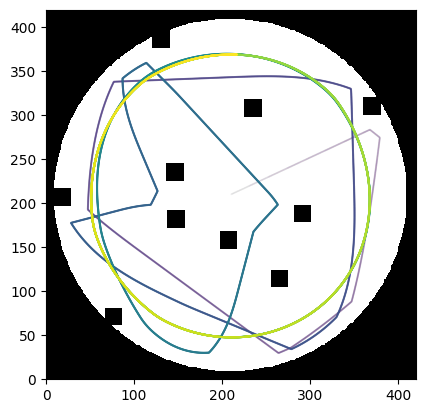

In [40]:
fig = plt.figure()
ax  = plt.subplot(111, aspect=1)
p0  = plt.pcolor(b_3.worldmap.T, cmap='Greys')

plt.scatter(X, Y, lw=0.5, s=1, 
          c=np.array(list_t)*1./T_tot, # later times, brighter color
          alpha=(0.01 + 0.99*np.array(list_t)/T_tot) , # later times, lower transparency
          )
plt.show()

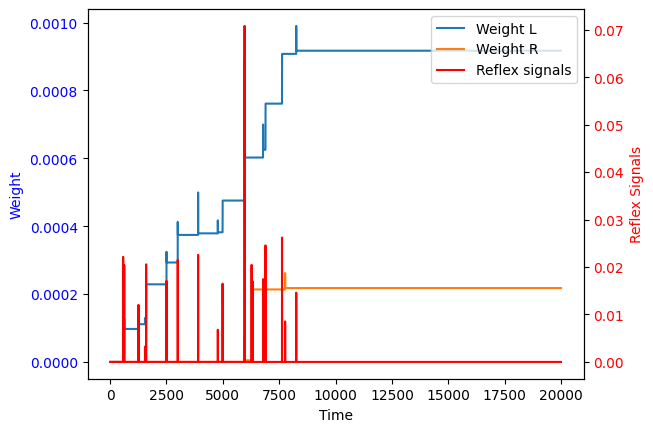

In [41]:
# Plot the primary y-axis data
fig, ax1 = plt.subplots()

# Plot Weight L and Weight R on the primary y-axis
ax1.plot(list_t, list_weight_L, label="Weight L")
ax1.plot(list_t, list_weight_R, label="Weight R")
ax1.set_xlabel("Time")
ax1.set_ylabel("Weight", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a twin y-axis to rescale reflex signals
ax2 = ax1.twinx()
ax2.plot(list_t, reflex_signals, label="Reflex signals", color='red')
ax2.set_ylabel("Reflex Signals", color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add legends
fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)

# Show the plot
plt.show()

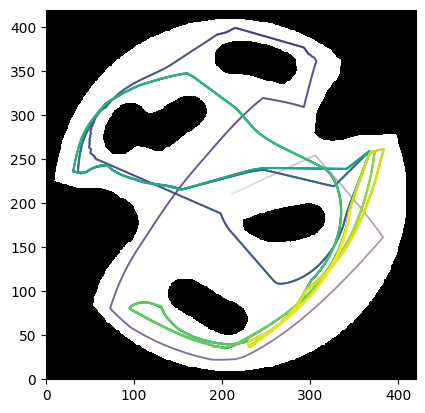

In [42]:
b_3 = BraitenbergEnvironment(filename="parcour_3.png",
                           vehicle_diameter=d, 
                           antenna_angle=angle, 
                           initial_orientation=orientation_init, 
                           short_antenna_length = l_0,
                           long_antenna_length  = 80)

X_L_0 = Neuron(0)
X_R_0 = Neuron(0)
X_L_1 = Neuron(0)
X_R_1 = Neuron(0)
X_L = Neuron(0)
X_R = Neuron(0)

s_L_0 = Synapse(X_L_0, X_L, learning_rate, weight=1)
s_R_0 = Synapse(X_R_0, X_R, learning_rate, weight=1)
s_R_1 = Synapse(X_R_1, X_R, learning_rate)
s_L_1 = Synapse(X_L_1, X_L, learning_rate)

motor_out = Neuron(0)
s_L_out = Synapse(X_L, motor_out, learning_rate, weight=-g_alpha)
s_R_out = Synapse(X_R, motor_out, learning_rate, weight=g_alpha)

motor_command = 0

X= []
Y = []
list_t = np.arange(T_tot)
reflex_signals = []

list_weight_L = []
list_weight_R = []

for t in list_t:
    x_t, y_t, orientation_t, sensors_t = b_3.world_update(motor_command)
    X.append(x_t)
    Y.append(y_t)

    X_L_0.rate = sensors_t[0]
    X_R_0.rate = sensors_t[1]
    X_L_1.rate = sensors_t[2]
    X_R_1.rate = sensors_t[3]
    X_L_1.rates.append(X_L_1.rate)
    X_R_1.rates.append(X_R_1.rate)
    X_L_0.rates.append(X_L_0.rate)
    X_R_0.rates.append(X_R_0.rate)

    r = np.max([X_L_0.rate, X_R_0.rate])
    reflex_signals.append(r)
    
    X_L.update_rate([s_L_0.weight, s_L_1.weight], [X_L_0.rate, X_L_1.rate])
    X_R.update_rate([s_R_0.weight, s_R_1.weight], [X_R_0.rate, X_R_1.rate])
    
    motor_out.update_rate([s_L_out.weight, s_R_out.weight], [X_L.rate, X_R.rate])

    motor_command = motor_out.rate
    
    s_L_1.update_weight('ico2')
    s_R_1.update_weight('ico2')
    list_weight_R.append(s_R_1.weight)
    list_weight_L.append(s_L_1.weight)
    
list_rates_L = X_L.rates
list_rates_R = X_R.rates

fig = plt.figure()
ax  = plt.subplot(111, aspect=1)
p0  = plt.pcolor(b_3.worldmap.T, cmap='Greys')

plt.scatter(X, Y, lw=0.5, s=1, 
          c=np.array(list_t)*1./T_tot, # later times, brighter color
          alpha=(0.01 + 0.99*np.array(list_t)/T_tot) , # later times, lower transparency
          )
plt.show()

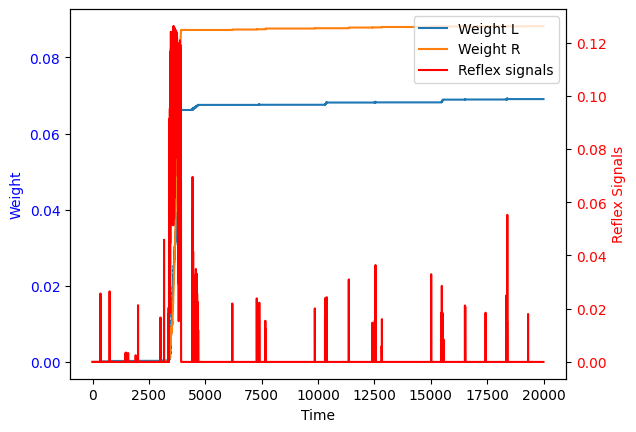

In [43]:
# Plot the primary y-axis data
fig, ax1 = plt.subplots()

# Plot Weight L and Weight R on the primary y-axis
ax1.plot(list_t, list_weight_L, label="Weight L")
ax1.plot(list_t, list_weight_R, label="Weight R")
ax1.set_xlabel("Time")
ax1.set_ylabel("Weight", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a twin y-axis to rescale reflex signals
ax2 = ax1.twinx()
ax2.plot(list_t, reflex_signals, label="Reflex signals", color='red')
ax2.set_ylabel("Reflex Signals", color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add legends
fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)

# Show the plot
plt.show()